# Data Definition:
Independent Variable

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)

Dependent Variable

- target - this denotes whether a tweet is about a real disaster (1) or not (0)

### Importing Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import re
import os
import nltk
from nltk.tokenize import word_tokenize
import  string 
from collections import defaultdict
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('twitter_data.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("{} rows and {} columns in dataset".format(df.shape[0],df.shape[1]))

7613 rows and 5 columns in dataset


In [4]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### EDA (Exploratory Data Analysis)

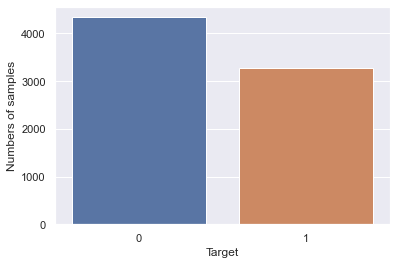

In [5]:
sns.countplot('target', data = df)
plt.xlabel("Target")
plt.ylabel('Numbers of samples')
plt.show()

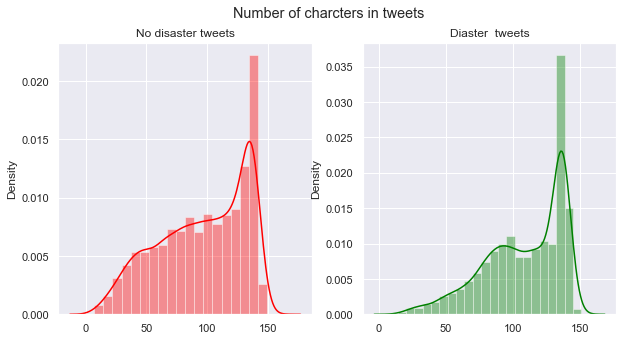

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))

no_of_zero = list(df[df['target'] == 0]['text'].map(len))
sns.distplot(no_of_zero, ax = ax1, color = 'red')

no_of_ones = list(df[df['target'] == 1]['text'].map(len))
sns.distplot(no_of_ones, ax = ax2, color = 'green')

ax1.set_title('No disaster tweets')
ax2.set_title('Diaster  tweets')

fig.suptitle('Number of charcters in tweets')
plt.show()

In [7]:
stopword = set(stopwords.words('english'))  #set of stopwords

# Common stopwords in tweets
def total_stopwords(data, target, stopwords):
    list_of_words=[]
    words = data[data['target'] == target]['text'].str.split()
    for word in words:
        for i in word:
              list_of_words.append(i)
    
    dictt = defaultdict(int)
    
    for list_word in list_of_words:
        if list_word in stopword:
            dictt[list_word] +=1
            
    top_10 = sorted(dictt.items(), key = lambda x : x[1], reverse=True)[:10] 
    
    x, y = zip(*top_10)
    plt.bar(x,y)
    plt.title("List of common words")
    plt.show()    

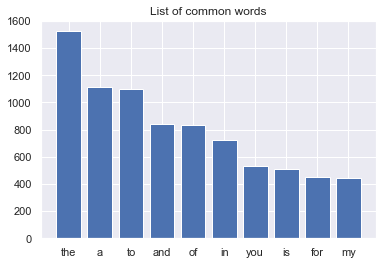

In [8]:
# Common words for No disaster tweets
total_stopwords(df, 0, stopwords)

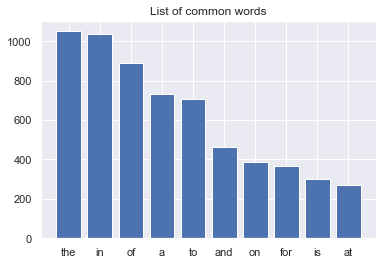

In [9]:
# Common words for Disaster tweets
total_stopwords(df, 1, stopwords)

In [10]:
# Useful Functions

def remove_between_square_brackets(text):
    """Removing Squear brackets from data"""
    return re.sub('\[[^]]*\]', '', text)

def remove_digits(text):
    """ Remove digits"""
    return re.sub('[&#\d%/$]', '', text)

def remove_url(text):
    """ Remove url's"""
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    """ Remove html tags"""
    html = re.compile(r'<.*?>')
    return html.sub(r"", text)

def remove_emojis(text):
    """Remove emojis"""
    # reference : https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/49146722#49146722
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    """Remove punctuation"""
    return re.sub(r'[^\w\s]', '', text)
     
     
def removing_noice(text):
    """All the functions into one function"""
    text = remove_between_square_brackets(text)
    text = remove_digits(text)
    text = remove_url(text)
    text = remove_html(text)
    text = remove_emojis(text)
    text = remove_punctuation(text)
    return text

In [11]:
#Aplying function to the text
df['text'] = df['text'].map(removing_noice)

In [12]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [13]:
def create_corpus(df):
    corpos = []
    for words in df['text']:
        tok = word_tokenize(words)
        data = [word.lower() for word in tok if((word.isalpha() == 1) & (word not in stopword))]
        corpos.append(data)
    return corpos

In [14]:
corpus = create_corpus(df)

### Using GloVe for Vectorization

In [15]:
embedding_dict={}
with open('glove.6B.100d.txt','r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors

In [16]:
# Implementing Tokenizer and pad_sequeces
MAX_LEN=50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

pad_obj = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [17]:
pad_obj

array([[ 596, 4349,  765, ...,    0,    0,    0],
       [ 117,    7,  156, ...,    0,    0,    0],
       [ 118, 1625, 1499, ...,    0,    0,    0],
       ...,
       [ 416,  548,  244, ...,    0,    0,    0],
       [  20, 1041, 3049, ...,    0,    0,    0],
       [   2,  139,   87, ...,    0,    0,    0]])

In [18]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 21191


In [19]:
import itertools
print(dict(itertools.islice(word_index.items(), 5)))

{'i': 1, 'the': 2, 'like': 3, 'a': 4, 'amp': 5}


In [20]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i > num_words:
        continue
        
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

In [21]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Building Model

In [22]:
model =  Sequential()
model.add(Embedding(num_words, 100, embeddings_initializer = Constant(embedding_matrix), 
                    input_length=MAX_LEN,trainable=False))

model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2119200   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,161,505
Trainable params: 42,305
Non-trainable params: 2,119,200
_________________________________________________________________


In [23]:
model.compile(optimizer = Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

### Spliting data into Train and Test

In [24]:
X_train, X_val, y_train, y_val = train_test_split(pad_obj, df.target.values, test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


### Training the model

In [25]:
history = model.fit(X_train, y_train, batch_size=5, epochs=20, 
                    validation_data = (X_val,y_val), verbose=2)

Epoch 1/20
1295/1295 - 42s - loss: 0.6774 - accuracy: 0.5894 - val_loss: 0.5805 - val_accuracy: 0.7566
Epoch 2/20
1295/1295 - 42s - loss: 0.5303 - accuracy: 0.7657 - val_loss: 0.5258 - val_accuracy: 0.7539
Epoch 3/20
1295/1295 - 41s - loss: 0.5036 - accuracy: 0.7756 - val_loss: 0.5106 - val_accuracy: 0.7618
Epoch 4/20
1295/1295 - 39s - loss: 0.4918 - accuracy: 0.7810 - val_loss: 0.4966 - val_accuracy: 0.7785
Epoch 5/20
1295/1295 - 41s - loss: 0.4809 - accuracy: 0.7869 - val_loss: 0.4884 - val_accuracy: 0.7820
Epoch 6/20
1295/1295 - 39s - loss: 0.4757 - accuracy: 0.7874 - val_loss: 0.4807 - val_accuracy: 0.7811
Epoch 7/20
1295/1295 - 37s - loss: 0.4642 - accuracy: 0.7996 - val_loss: 0.4766 - val_accuracy: 0.7828
Epoch 8/20
1295/1295 - 37s - loss: 0.4618 - accuracy: 0.7979 - val_loss: 0.4715 - val_accuracy: 0.7828
Epoch 9/20
1295/1295 - 37s - loss: 0.4559 - accuracy: 0.8039 - val_loss: 0.4703 - val_accuracy: 0.7890
Epoch 10/20
1295/1295 - 38s - loss: 0.4550 - accuracy: 0.7999 - val_loss:

In [26]:
def plot_results(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    plt.plot(training_accuracy, label = 'train_acc')
    plt.plot(validation_accuracy, label = 'val_acc')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.plot(training_loss, label = 'train_loss')
    plt.plot(validation_loss, label = 'val_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

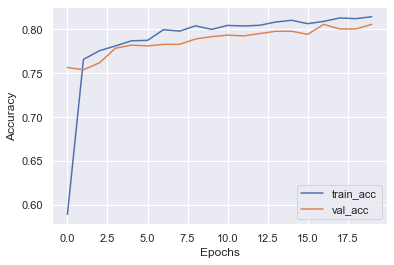

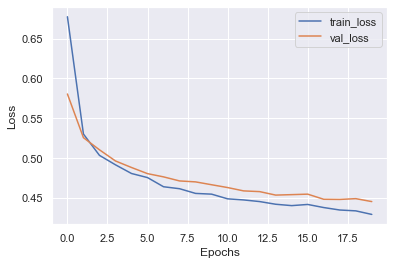

In [27]:
plot_results(history)

In [28]:
model_json = model.to_json()
with open("tweet.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("tweet.h5")
print("Saved model to disk !!!")

Saved model to disk !!!
